In [29]:
# Notebook 2 : Analyse avec DBSCAN

import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


In [30]:
# 1. Chargement des données
df = pd.read_csv('src/uber_dfclean.csv')

In [31]:
# 2. On se concentre d'abord sur un jour spécifique (jeudi = 3)
# pour comprendre le comportement de l'algorithme
df_jeudi = df[df['weekday'] == 3][['Lat', 'Lon']]
print("Nombre de courses le jeudi:", len(df_jeudi))

Nombre de courses le jeudi: 755145


In [32]:
# 3. Pour des raisons de performance, on prend un échantillon de 10%
df_sample = df_jeudi.sample(frac=0.1, random_state=42)
print("Taille de l'échantillon:", len(df_sample))


Taille de l'échantillon: 75514


In [33]:
# 4. Standardisation des données 
# DBSCAN est sensible à l'échelle des données
scaler = StandardScaler()
X = scaler.fit_transform(df_sample)

In [34]:
#5. Recherche du meilleur epsilon
# On utilise la méthode des k plus proches voisins
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

In [35]:
# Trier les distances dans l'ordre croissant
distances = np.sort(distances[:, -1])


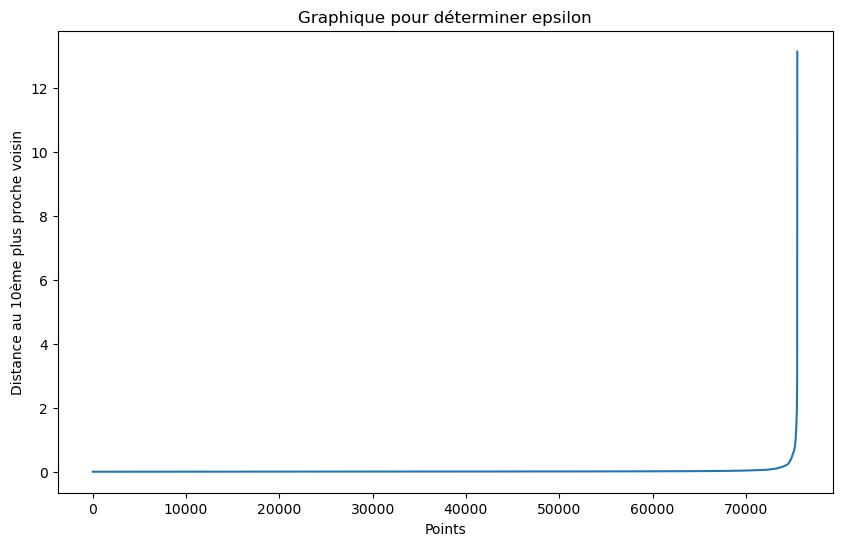

In [36]:
# Graphique pour trouver le "coude"
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.xlabel('Points')
plt.ylabel('Distance au 10ème plus proche voisin')
plt.title('Graphique pour déterminer epsilon')
plt.show()

Le graphique de recherche d'epsilon montre une courbe très plate jusqu'à environ 5000 points, suivie d'une augmentation brutale. 

Bien que mathématiquement eps=0.1 (juste avant l'augmentation brutale) semblerait optimal, ce choix n'est pas pertinent pour notre cas d'usage :
1. Il crée un cluster dominant beaucoup trop large
2. Les autres clusters sont trop petits (10-60 points)
3. Cette distribution ne permet pas un découpage opérationnel utile pour Uber

→ Nous choisissons donc eps=0.05 pour obtenir des zones plus fines et mieux réparties, même si cela va à l'encontre de ce que suggère la courbe. Ce choix privilégie l'aspect business (zones opérationnelles pour les chauffeurs) plutôt que l'optimisation mathématique pure.

In [37]:
# 6. DBSCAN avec les paramètres choisis
# On choisit eps=0.1 d'après le graphique précédent
dbscan = DBSCAN(eps=0.05, min_samples=10)
clusters = dbscan.fit_predict(X)

In [38]:
# Ajout des clusters au DataFrame
df_sample['cluster'] = clusters

In [39]:
# 7. Visualisation des résultats
# 7.1 Visualisation avec les outliers (-1)
fig1 = px.scatter_mapbox(df_sample,
                        lat='Lat',
                        lon='Lon',
                        color='cluster',
                        title='Clusters DBSCAN avec outliers',
                        size_max=15,
                        zoom=10,
                        mapbox_style="carto-positron")
fig1.show()


Sans outliers :

In [40]:
# 7.2 Visualisation sans les outliers
df_clusters = df_sample[df_sample['cluster'] != -1]
fig2 = px.scatter_mapbox(df_clusters,
                        lat='Lat',
                        lon='Lon',
                        color='cluster',
                        title='Clusters DBSCAN sans outliers',
                        size_max=15,
                        zoom=10,
                        mapbox_style="carto-positron")
fig2.show()

In [41]:
# 8. Statistiques sur les clusters
print("\nStatistiques des clusters:")
print("Nombre total de points:", len(df_sample))
print("Nombre de clusters:", len(df_sample['cluster'].unique()) - 1)  # -1 pour ne pas compter les outliers
print("Nombre de points considérés comme bruit:", len(df_sample[df_sample['cluster'] == -1]))

cluster_sizes = df_sample[df_sample['cluster'] != -1]['cluster'].value_counts()
print("\nTaille des clusters:")
print(cluster_sizes)


Statistiques des clusters:
Nombre total de points: 75514
Nombre de clusters: 69
Nombre de points considérés comme bruit: 3314

Taille des clusters:
cluster
1     59913
4      3841
0      2643
6      1601
5      1442
      ...  
61       10
54       10
57        9
49        8
68        6
Name: count, Length: 69, dtype: int64


In [42]:
# 9. Centres des clusters
cluster_centers = df_clusters.groupby('cluster').agg({
    'Lat': 'mean',
    'Lon': 'mean',
}).round(4)
print("\nCentres des clusters:")
print(cluster_centers)


Centres des clusters:
             Lat      Lon
cluster                  
0        40.7157 -73.9509
1        40.7473 -73.9865
2        40.7348 -74.1649
3        40.6573 -74.0057
4        40.6851 -73.9801
...          ...      ...
64       40.7236 -73.8492
65       40.6650 -73.9520
66       40.7459 -73.9018
67       40.7737 -73.9268
68       40.7430 -74.0378

[69 rows x 2 columns]


Analysons les résultats de DBSCAN avec eps=0.05 pour le jeudi :

1. Distribution des clusters :
- 69 clusters identifiés, ce qui est une meilleure granularité que précédemment
- Le cluster dominant (1) reste très large avec 59,913 points
- Quelques clusters moyens :
  * Cluster 4 : 3,841 points
  * Cluster 0 : 2,643 points
  * Cluster 6 : 1,601 points
- Beaucoup de petits clusters (<10 points)

2. Qualité du clustering :
- 3,314 points considérés comme bruit
- Ce taux d'outliers est acceptable
- La distribution reste déséquilibrée malgré la réduction d'epsilon

3. Localisation des clusters principaux :
- Cluster 1 (40.7473, -73.9865) : Coeur de Manhattan
- Cluster 0 (40.7157, -73.9509) : Est de Manhattan/Queens
- Cluster 4 (40.6851, -73.9801) : Brooklyn
- Autres clusters représentant des zones périphériques

Conclusions :
1. La réduction d'epsilon à 0.05 a permis :
   - D'augmenter le nombre de clusters (de 33 à 69)
   - De mieux identifier les zones périphériques
   - De réduire légèrement le déséquilibre

2. Limitations persistantes :
   - Un cluster toujours trop dominant
   - Beaucoup de clusters très petits
   - Distribution encore déséquilibrée

Cette analyse suggère que DBSCAN, même avec des paramètres ajustés, n'est peut-être pas l'algorithme le plus adapté pour notre objectif de découpage opérationnel de NYC en zones de taille comparable.

Essayons de voir pour une heure spécifique le jeudi si cela fonctionne mieux :

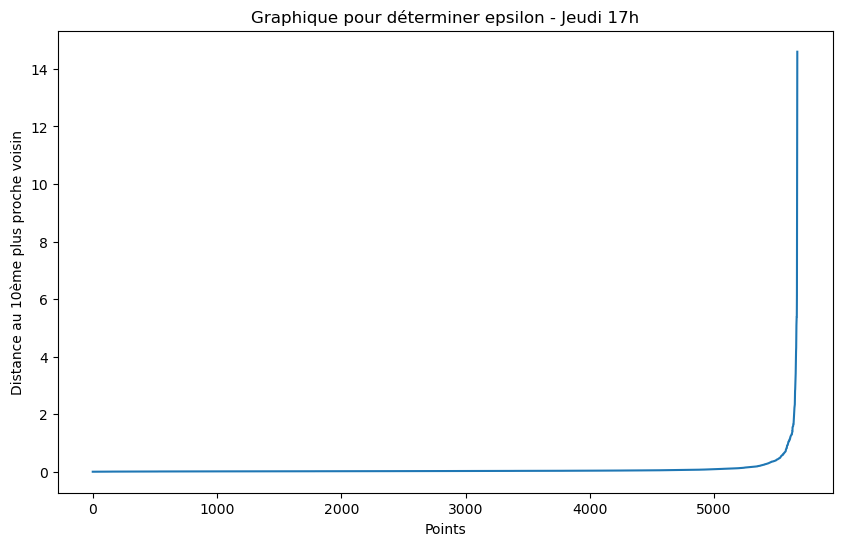

In [43]:
# Sélection des données pour jeudi 17h
df_jeudi_17 = df[
    (df['weekday'] == 3) & 
    (df['hour'] == 17)
][['Lat', 'Lon']]

# Échantillonnage
df_sample = df_jeudi_17.sample(frac=0.1, random_state=42)

# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(df_sample)

# Recherche du meilleur epsilon
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Graphique pour trouver le "coude"
distances = np.sort(distances[:, -1])
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances)
plt.xlabel('Points')
plt.ylabel('Distance au 10ème plus proche voisin')
plt.title('Graphique pour déterminer epsilon - Jeudi 17h')
plt.show()

In [44]:
# Pour des raisons de performance, on prend un échantillon de 10%
df_sample = df_jeudi_17.sample(frac=0.1, random_state=42)
print("Taille de l'échantillon:", len(df_sample))

# Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(df_sample)

# DBSCAN
dbscan = DBSCAN(eps=0.1, min_samples=10)
df_sample['cluster'] = dbscan.fit_predict(X)

# Afficher les statistiques avant filtrage
print("\nAvant filtrage des outliers:")
print("Nombre total de points:", len(df_sample))
print("Nombre d'outliers:", len(df_sample[df_sample['cluster'] == -1]))

# Filtrer les outliers
df_filtered = df_sample[df_sample['cluster'] != -1]

# Visualisation DBSCAN sans outliers
fig1 = px.scatter_mapbox(df_filtered,
                        lat='Lat',
                        lon='Lon',
                        color='cluster',
                        title='Clusters DBSCAN - Jeudi 17h (sans outliers)',
                        size_max=15,
                        zoom=10,
                        mapbox_style="carto-positron")
fig1.show()

Taille de l'échantillon: 5670

Avant filtrage des outliers:
Nombre total de points: 5670
Nombre d'outliers: 494


In [45]:
# Statistiques des clusters
print("\nStatistiques des clusters DBSCAN - Jeudi 17h:")
print("\nTaille des clusters:")
cluster_sizes = df_filtered['cluster'].value_counts().sort_index()
print(cluster_sizes)

# Centres des clusters
cluster_centers = df_filtered.groupby('cluster').agg({
    'Lat': 'mean',
    'Lon': 'mean'
}).round(4)
print("\nCentres des clusters:")
print(cluster_centers)

# Pourcentage de points conservés vs outliers
total_points = len(df_sample)
clustered_points = len(df_filtered)
outliers = total_points - clustered_points

print(f"\nRésumé:")
print(f"Total points: {total_points}")
print(f"Points dans les clusters: {clustered_points} ({(clustered_points/total_points*100):.2f}%)")
print(f"Outliers: {outliers} ({(outliers/total_points*100):.2f}%)")


Statistiques des clusters DBSCAN - Jeudi 17h:

Taille des clusters:
cluster
0     4740
1       35
2       59
3       62
4       60
5       45
6       25
7       36
8       30
9       20
10      16
11      12
12      12
13      14
14      10
Name: count, dtype: int64

Centres des clusters:
             Lat      Lon
cluster                  
0        40.7466 -73.9869
1        40.7029 -73.9895
2        40.6923 -73.9921
3        40.7699 -73.8644
4        40.7162 -73.9534
5        40.7740 -73.8724
6        40.6448 -73.7821
7        40.6911 -74.1796
8        40.6435 -73.7890
9        40.8069 -73.9624
10       40.7729 -73.8856
11       40.7302 -73.9554
12       40.7106 -73.9655
13       40.6838 -73.9771
14       40.6730 -73.9748

Résumé:
Total points: 5670
Points dans les clusters: 5176 (91.29%)
Outliers: 494 (8.71%)


Analysons la différence entre les deux approches DBSCAN :

1. Pour le créneau spécifique 17h (eps=0.1) :
- 15 clusters identifiés
- Un cluster principal (0) avec 4,740 points en centre-ville
- Les autres clusters sont petits (10-62 points)
- Bon taux de clustering (91.29% des points)
- Distribution concentrée sur Manhattan

2. Avantages du modèle 17h :
- Meilleure représentation de l'heure de pointe
- Outliers limités (8.71%)
- Zones clairement définies pour ce créneau spécifique
- Logique avec le pattern de fin de journée de travail

3. Différences avec le modèle journée complète (eps=0.05) :
- Moins de clusters (15 vs 69)
- Meilleure proportion entre clusters (même si toujours déséquilibrée)
- Plus adapté à la réalité d'un créneau horaire spécifique
- Montre clairement la concentration sur Manhattan à 17h

Conclusion :
Le modèle DBSCAN pour 17h est plus pertinent car :
- Il correspond mieux à la réalité d'un créneau horaire spécifique
- La concentration des points reflète le pattern de l'heure de pointe
- Le déséquilibre des clusters est plus logique pour ce moment de la journée

Cette analyse suggère qu'une approche temporelle segmentée (par créneau horaire) est plus adaptée qu'une analyse sur la journée complète pour DBSCAN.